In [1]:
import os
import sys
from pathlib import Path
project_dir = Path().resolve().parent.parent
sys.path.append(str(project_dir))


os.environ['USE_PYGEOS'] = os.environ.get('USE_PYGEOS', '0')

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from IPython.display import Markdown

from masterplan_tools.method import MasterPlan
from masterplan_tools.method.provision import ProvisionModel
from masterplan_tools.models import CityModel
from masterplan_tools.preprocessing import DataGetter



def pandas_to_markdown(df_or_series: pd.DataFrame | pd.Series, value_name: str | None = None) -> Markdown:
    if isinstance(df_or_series, pd.DataFrame):
        return Markdown(
            "\n".join(
                (
                    f"| {' | '.join(column for column in df_or_series.columns)} |",
                    f"| {' | '.join(('---',) * df_or_series.shape[1])} |",
                    "\n".join(
                        f"| {' | '.join(str(value) for value in values)} |" for _, values in df_or_series.iterrows()
                    ),
                )
            )
        )
    elif isinstance(df_or_series, pd.Series):
        if value_name is None:
            value_name = "value"
        return Markdown(
            "\n".join(
                (
                    f"| {df_or_series.name} | {value_name} |",
                    "| --- | --- |",
                    "\n".join(f"| {key} | {round(value)} |" for key, value in df_or_series.items()),
                )
            )
        )
    raise ValueError(f"'{df_or_series}' is neither DataFrame nor Series")

c:\masterplanning\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# path to data
example_data_path = "./data"
# TODO: upload example data somewhere and download it in script

# load blocks from blocks_cutter.ipynb
blocks = gpd.read_parquet(os.path.join(example_data_path, "blocks_cutter_result.parquet")) 

# load data required for service graphs creation
schools = gpd.read_parquet(os.path.join(example_data_path, "schools.parquet"))
kindergartens = gpd.read_parquet(os.path.join(example_data_path, "kindergartens.parquet"))
recreational_areas = gpd.read_parquet(os.path.join(example_data_path, "recreational_areas.parquet"))

hospitals = gpd.read_file(os.path.join(example_data_path, "hospitals.geojson"))
pharmacies = gpd.read_file(os.path.join(example_data_path, "pharmacies.geojson"))
policlinics = gpd.read_file(os.path.join(example_data_path, "policlinics.geojson"))

# load data required for
buildings = gpd.read_parquet(os.path.join(example_data_path, "buildings.parquet"))
greenings = gpd.read_parquet(os.path.join(example_data_path, "greenings.parquet"))
parkings = gpd.read_parquet(os.path.join(example_data_path, "parkings.parquet"))

transport_graph = nx.read_graphml(os.path.join(example_data_path, "new_graph.graphml"))

# data loading with planning area
polygon = gpd.read_file(os.path.join(example_data_path, "polygon.geojson"))

In [3]:
# services should be specified as a dictionary
services = {"schools": schools, "kindergartens": kindergartens, "recreational_areas": recreational_areas,
            "hospitals": hospitals, "pharmacies": pharmacies, "policlinics": policlinics}

<Axes: >

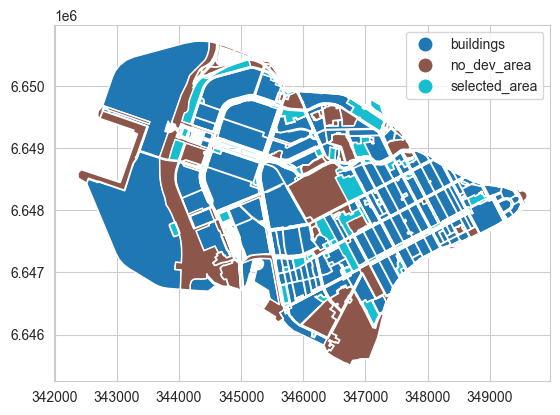

In [4]:
blocks.plot(column='landuse', legend=True)

In [5]:

# block_t = gpd.read_parquet(os.path.join(example_data_path, "blocks123.parquet"))
block_t = blocks
block_t.reset_index(drop=True, inplace=True)
block_t['id'] = block_t.index
block_t['index'] = block_t['id']
block_t.drop('landuse', axis=1, inplace=True)
block_t.reset_index(drop=True, inplace=True)


In [6]:
buildings

,population_balanced,building_area,living_area,storeys_count,is_living,geometry,living_area_pyatno,total_area
0,0,439.9230,0.0,2.0,False,POINT (346419.440 6645746.556),0.0,879.846
1,0,90.8479,0.0,0.0,False,POINT (346404.511 6645778.545),0.0,0.000
2,0,54.8750,0.0,0.0,False,POINT (346393.945 6645794.323),0.0,0.000
3,0,158.6920,0.0,0.0,False,POINT (346419.604 6645798.198),0.0,0.000
4,0,205.0480,0.0,0.0,False,POINT (346393.335 6645817.967),0.0,0.000
...,...,...,...,...,...,...,...,...
3743,0,18.8506,0.0,0.0,False,POINT (345029.285 6650377.778),0.0,0.000
3744,0,15.4680,0.0,0.0,False,POINT (345038.615 6650380.285),0.0,0.000
3745,0,17.5489,0.0,0.0,False,POINT (345050.448 6650383.702),0.0,0.000
3746,0,16.1324,0.0,0.0,False,POINT (345058.378 6650385.834),0.0,0.000


In [8]:
from masterplan_tools import CityModel

city_model = CityModel(
  blocks=aggregated_blocks,
  accessibility_matrix=accessibility_matrix,
  services=services
)

NameError: name 'aggregated_blocks' is not defined

In [ ]:
services_prov = {}

for service_type in services.keys():
    provision = ProvisionModel(city_model=city_model, service_name=service_type)
    print(service_type)
    services_prov[service_type] = provision.run()

schools
kindergartens
recreational_areas
hospitals
pharmacies
policlinics


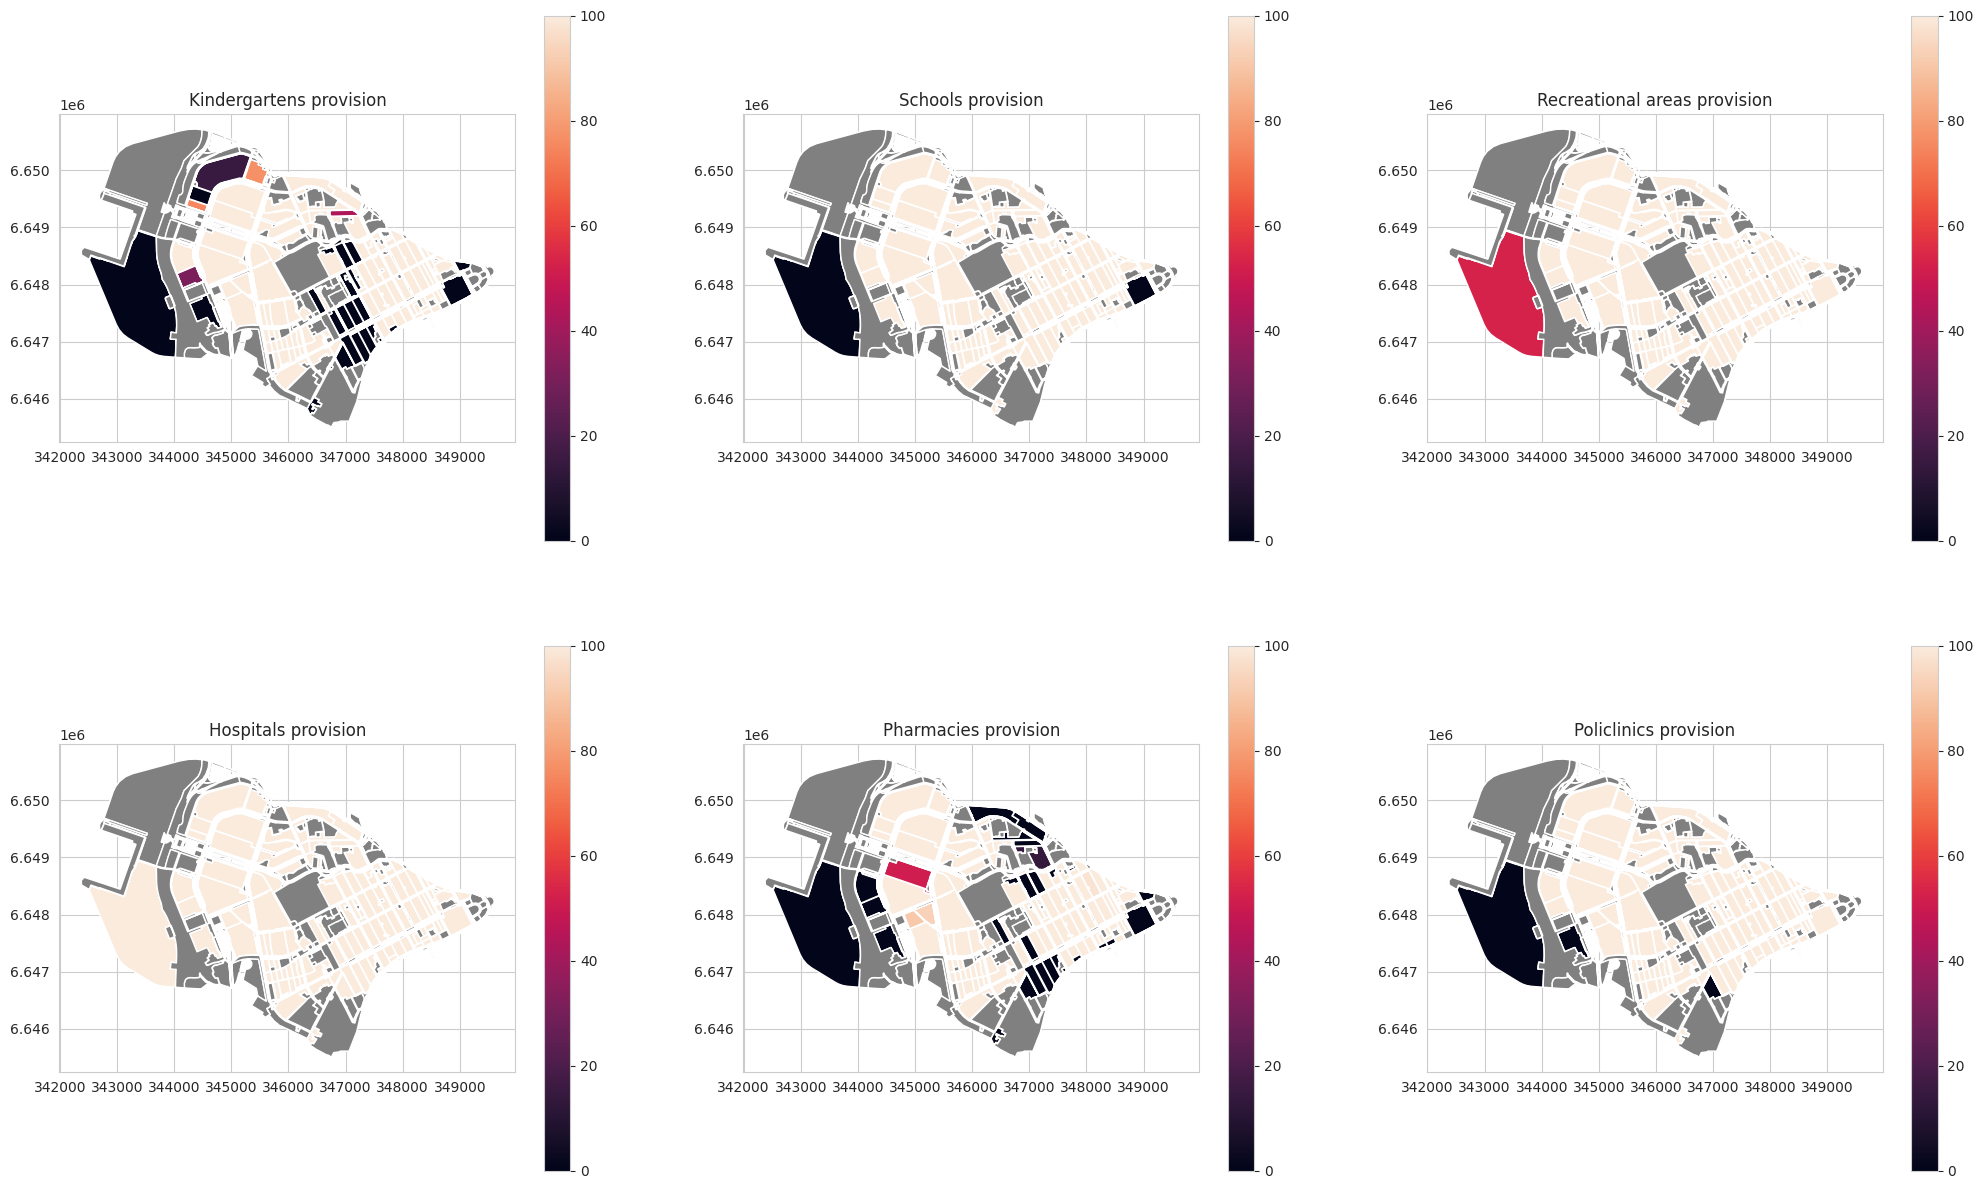

In [ ]:
from matplotlib.gridspec import GridSpec

kindergartens_prov = services_prov["kindergartens"]
schools_prov = services_prov["schools"]
recreational_areas_prov = services_prov["recreational_areas"]
hospitals_prov = services_prov["hospitals"]
pharmacies_prov = services_prov["pharmacies"]
policlinics_prov = services_prov["policlinics"]

fig = plt.figure(figsize=(25, 15))
gs = GridSpec(2, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
kindergartens_prov.plot(column="provision_kindergartens", legend=True, ax=ax1)
ax1.set_title("Kindergartens provision")
kindergartens_prov[kindergartens_prov["population"] == 0].plot(ax=ax1, color="grey", alpha=1)

ax2 = fig.add_subplot(gs[0, 1])
schools_prov.plot(column="provision_schools", legend=True, ax=ax2)
ax2.set_title("Schools provision")
schools_prov[schools_prov["population"] == 0].plot(ax=ax2, color="grey", alpha=1)

ax3 = fig.add_subplot(gs[0, 2])
recreational_areas_prov.plot(column="provision_recreational_areas", legend=True, ax=ax3)
ax3.set_title("Recreational areas provision")
recreational_areas_prov[recreational_areas_prov["population"] == 0].plot(ax=ax3, color="grey", alpha=1)

ax4 = fig.add_subplot(gs[1, 0])
hospitals_prov.plot(column="provision_hospitals", legend=True, ax=ax4)
ax4.set_title("Hospitals provision")
hospitals_prov[hospitals_prov["population"] == 0].plot(ax=ax4, color="grey", alpha=1)

ax5 = fig.add_subplot(gs[1, 1])
pharmacies_prov.plot(column="provision_pharmacies", legend=True, ax=ax5)
ax5.set_title("Pharmacies provision")
pharmacies_prov[pharmacies_prov["population"] == 0].plot(ax=ax5, color="grey", alpha=1)

ax6 = fig.add_subplot(gs[1, 2])
policlinics_prov.plot(column="provision_policlinics", legend=True, ax=ax6)
ax6.set_title("Policlinics provision")
policlinics_prov[policlinics_prov["population"] == 0].plot(ax=ax6, color="grey", alpha=1)

plt.show()

In [ ]:
prov = pd.concat([df if i==0 else df.drop(['id', 'geometry', 'population'], axis=1) for i, df in enumerate(services_prov.values())], axis=1)

In [ ]:
prov.drop('level_0', axis=1, inplace=True)
prov

,geometry,id,provision_schools,population_prov_schools,population_unprov_schools,population,provision_kindergartens,population_prov_kindergartens,population_unprov_kindergartens,provision_recreational_areas,...,population_unprov_recreational_areas,provision_hospitals,population_prov_hospitals,population_unprov_hospitals,provision_pharmacies,population_prov_pharmacies,population_unprov_pharmacies,provision_policlinics,population_prov_policlinics,population_unprov_policlinics
0,"POLYGON ((344943.719 6647610.514, 344959.205 6...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"POLYGON ((344968.687 6647544.000, 344971.625 6...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"POLYGON ((344929.592 6647257.521, 344931.964 6...",2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"POLYGON ((344840.676 6647432.974, 344853.943 6...",3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"POLYGON ((344856.398 6647391.171, 344900.097 6...",4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349,"POLYGON ((346243.206 6647701.284, 346243.206 6...",1349,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1350,"POLYGON ((347483.986 6647345.029, 347483.627 6...",1350,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1351,"POLYGON ((347463.977 6647381.345, 347456.841 6...",1351,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1352,"POLYGON ((344028.826 6648834.242, 344112.884 6...",1352,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df = city_model.blocks_aggregated_info.merge(prov)
del prov
df

,level_0,geometry,block_id,current_population,floors,current_living_area,current_green_capacity,current_green_area,current_parking_capacity,current_industrial_area,...,population_unprov_recreational_areas,provision_hospitals,population_prov_hospitals,population_unprov_hospitals,provision_pharmacies,population_prov_pharmacies,population_unprov_pharmacies,provision_policlinics,population_prov_policlinics,population_unprov_policlinics
0,0,"POLYGON ((344943.719 6647610.514, 344959.205 6...",0,0.0,NaN,0.0,0.0,0.0,0.0,0.0000,...,0,0,0,0,0,0,0,0,0,0
1,1,"POLYGON ((344968.687 6647544.000, 344971.625 6...",1,0.0,NaN,0.0,0.0,0.0,0.0,0.0000,...,0,0,0,0,0,0,0,0,0,0
2,2,"POLYGON ((344929.592 6647257.521, 344931.964 6...",2,0.0,0.0,0.0,0.0,0.0,0.0,42.6397,...,0,0,0,0,0,0,0,0,0,0
3,3,"POLYGON ((344840.676 6647432.974, 344853.943 6...",3,0.0,NaN,0.0,0.0,0.0,0.0,0.0000,...,0,0,0,0,0,0,0,0,0,0
4,4,"POLYGON ((344856.398 6647391.171, 344900.097 6...",4,0.0,NaN,0.0,0.0,0.0,0.0,0.0000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349,1349,"POLYGON ((346243.206 6647701.284, 346243.206 6...",1349,0.0,NaN,0.0,0.0,0.0,0.0,0.0000,...,0,0,0,0,0,0,0,0,0,0
1350,1350,"POLYGON ((347483.986 6647345.029, 347483.627 6...",1350,0.0,NaN,0.0,0.0,0.0,0.0,0.0000,...,0,0,0,0,0,0,0,0,0,0
1351,1351,"POLYGON ((347463.977 6647381.345, 347456.841 6...",1351,0.0,NaN,0.0,0.0,0.0,0.0,0.0000,...,0,0,0,0,0,0,0,0,0,0
1352,1352,"POLYGON ((344028.826 6648834.242, 344112.884 6...",1352,0.0,3.0,0.0,0.0,0.0,0.0,1535.7700,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df = df[['block_id', 'geometry' , 'current_population', 'population', 'area',
    'floors', 'current_living_area', 'current_industrial_area',
    'current_green_area',
    'current_green_capacity', 'current_parking_capacity',
    'population_prov_schools', 'population_unprov_schools',
    'population_prov_kindergartens', 'population_unprov_kindergartens',
    'population_prov_recreational_areas', 'population_unprov_recreational_areas',
    'population_prov_hospitals', 'population_unprov_hospitals',
    'population_prov_policlinics', 'population_unprov_policlinics',
    'population_prov_pharmacies', 'population_unprov_pharmacies']]

In [ ]:
# df.isna().sum()[df.isna().sum()!=0]
# df[df['floors'].isna()][['population', 'current_living_area']].describe()
df['floors'].fillna(0, inplace=True)
# (df['current_population'] != df['population']).sum()
df.drop(['current_population'], axis=1, inplace=True)

/tmp/ipykernel_20110/1962215181.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['floors'].fillna(0, inplace=True)
/tmp/ipykernel_20110/1962215181.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['current_population'], axis=1, inplace=True)


In [ ]:
HECTARE_IN_SQUARE_METERS = 10_000

df[['area', 'current_living_area', 'current_industrial_area', 'current_green_area']] = df[['area', 'current_living_area', 'current_industrial_area', 'current_green_area']]/HECTARE_IN_SQUARE_METERS

/home/vasilstar/masterplanning/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
df['free_area'] = df['area']*0.8 - df['current_green_area'] - df['current_industrial_area'] - df['current_living_area']

/home/vasilstar/masterplanning/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
services_dict = {
    'schools': {250: 1.2, 300: 1.1, 600: 1.3, 800: 1.5, 1100: 1.8},
    'kindergartens': {180: 0.72, 250: 1.44, 280: 1.1},
    'recreational_areas': {1000: 0.12},
    'pharmacies': {1000: 0.005},
    'hospitals': {500: 4, 1000: 8, 5000: 40, 10000: 80},
    'policlinics': {1000: 1.1, 3000: 3, 5000: 5}
}

In [ ]:
d = {}
for k,v in services_dict.items():
    for kk,vv in v.items():
        d[k+'_'+str(kk)]=vv
d_ = pd.DataFrame([d]).T

In [ ]:
d_

,0
schools_250,1.200
schools_300,1.100
schools_600,1.300
schools_800,1.500
schools_1100,1.800
kindergartens_180,0.720
kindergartens_250,1.440
kindergartens_280,1.100
recreational_areas_1000,0.120
pharmacies_1000,0.005


In [ ]:
import itertools

In [ ]:
comb = [list(itertools.combinations(list(d.keys()), i)) for i in range(1, 4)]
comb = [item for sublist in comb for item in sublist]

In [ ]:
comb_w = []
for comb_ in comb:
    comb_w.append(d_.loc[list(comb_)].sum()[0])

In [ ]:
df['variants'] = df['free_area'].apply(lambda x: [i for i,com in enumerate(comb_w) if com<=x])

/home/vasilstar/masterplanning/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
df['variants']

0                                                      []
1                                                     [9]
2                                                      []
3                                                      []
4                                                     [9]
                              ...                        
1349                                                   []
1350                                                   []
1351                                                   []
1352    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16,...
1353                                                  [9]
Name: variants, Length: 1354, dtype: object

In [ ]:
total_vars = list(set([item for sublist in df['variants'].tolist() for item in sublist]))

In [ ]:
variants = pd.DataFrame(columns=services.keys(), index=range(833)).fillna(0)
for i,_ in enumerate(comb):
    for el in [x.rsplit('_', maxsplit=1) for x in _]:
        variants.loc[i, el[0]] += int(el[1])

In [ ]:
variants

,schools,kindergartens,recreational_areas,hospitals,pharmacies,policlinics
0,250,0,0,0,0,0
1,300,0,0,0,0,0
2,600,0,0,0,0,0
3,800,0,0,0,0,0
4,1100,0,0,0,0,0
...,...,...,...,...,...,...
828,0,0,0,5000,0,8000
829,0,0,0,10000,0,4000
830,0,0,0,10000,0,6000
831,0,0,0,10000,0,8000


In [ ]:
import numpy as np

In [ ]:
blocks = np.zeros(140)

In [ ]:
blocks_for_change = np.random.randint(0, 140, 10)
change_variants = np.random.randint(0, 832, 10)

In [ ]:
blocks[blocks_for_change] = change_variants

In [ ]:
def fitness_func(ga_instance, blocks, solution_idx):
    updated_block_dict = {}

    for i, block_id in enumerate(blocks.nonzero()[0]):
        updated_block = {
            'block_id': df.loc[block_id]['block_id'],
            'population': df.loc[block_id]['population']}
        for k,v in variants.loc[blocks[block_id]].to_dict().items():
            updated_block[k+'_capacity'] = v

        updated_block_dict[i] = updated_block

    services_graph_new = nx.Graph()
    for service_type in services.keys():
        services_graph_new = DataGetter().prepare_graph(
            blocks=city_model.city_blocks,
            service_type=service_type,
            buildings=city_model.buildings,
            service_gdf=city_model.services_gdfs[service_type],
            updated_block_info=updated_block_dict,
            accessibility_matrix=city_model.accessibility_matrix,
            services_graph=services_graph_new,
        )

    city_model.services_graph = services_graph_new

    services_prov = {}
    for service_type in services.keys():
        provision = ProvisionModel(city_model=city_model, service_name=service_type)
        temp = provision.run()
        temp = temp[temp['population']!=0]
        services_prov[service_type] = 1/6*(temp['population_prov_' + service_type]/
                                           (temp['population_prov_' + service_type] +
                                            temp['population_unprov_' + service_type])).mean()

    fitness = sum(services_prov.values())

    return fitness

In [ ]:
fitness_func(None, blocks, None)

0.9346715982723066

In [ ]:
df['len_variants'] = df['variants'].apply(lambda x: len(x))

/home/vasilstar/masterplanning/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
import pygad

In [ ]:
ga_instance = pygad.GA(num_generations=3,
                       num_parents_mating=6,

                       fitness_func=fitness_func,

                       sol_per_pop=6,
                       num_genes=df[df['len_variants']!=0].reset_index(drop=True).shape[0],
                       gene_space=df[df['len_variants']!=0].reset_index(drop=True)['variants'].tolist(),
                       gene_type=int,

                       mutation_type='adaptive',
                       mutation_percent_genes=(90, 10),

                       # on_crossover = on_crossover,
                       crossover_type='scattered',

                       parent_selection_type='tournament',
                       K_tournament=3,

                       stop_criteria='saturate_50',
                       parallel_processing=12)

In [ ]:
# ga_instance.plot_fitness()

In [ ]:
solution = ga_instance.best_solution()[0]

In [ ]:
updated_block_dict = {}

for i, block_id in enumerate(solution.nonzero()[0]):
    updated_block = {
        'block_id': df.loc[block_id]['block_id'],
        'population': df.loc[block_id]['population']}
    for k,v in variants.loc[solution[block_id]].to_dict().items():
        updated_block[k+'_capacity'] = v

    updated_block_dict[i] = updated_block

In [ ]:
# city_model.services_graph = services_graph
# services_prov = {}
# for service_type in services.keys():
#     provision = ProvisionModel(city_model=city_model, service_name=service_type)
#     services_prov[service_type] = provision.run()

In [ ]:
comb[9]

('pharmacies_1000',)

In [ ]:
solution

array([  9,   9,   8,   9,   9,   9,   9,   9, 277, 433, 218,  49, 691,
         9, 171, 395, 547, 198,   9, 441,   9, 117,   9,   9,   9,   9,
         9, 546, 577, 381, 583,  90,  89,   5, 753, 736, 445,  76, 366,
         9, 185,   9,   9,   9,   9,   8, 304,   9, 632,  53,   8,   8,
       117,   9, 117,   8, 117,  90,   5,   9,   9,   9, 229, 165, 774,
         9,  89,   9, 421,   9, 117, 279, 523,  14,   1,   9,   9, 276,
        75,   9,   9,   9,   9,  88,   9,  99, 225,   9, 215, 489,  66,
         8,  45, 117, 129, 677,  30,  33, 484,   6,   8,   9,   9,   8,
         9, 342,   9, 483,   9,  40,  54,   9,   9,   9, 122, 347,   9,
       108, 438,  21,   9,   9, 292,   9,   9,   9,   9,   9,   8,   9,
         9, 117,   9,   0,  87,  90, 334,  25, 713, 117,   9,   9,  90,
       117,   8,   9,  18, 425,   9,  24,   9,   9,   8, 117,   9,   9,
         9,   9,   9,  39,   9,   8,   5,   9,   8, 117,   7, 100,   8,
       511,   5, 109, 210,   3,   9,  79, 237,   8, 117, 117,   

In [ ]:
services_graph_new = nx.Graph()
for service_type in services.keys():
    services_graph_new = DataGetter().prepare_graph(
        blocks=city_model.city_blocks,
        service_type=service_type,
        buildings=city_model.buildings,
        service_gdf=city_model.services_gdfs[service_type],
        updated_block_info=updated_block_dict,
        accessibility_matrix=city_model.accessibility_matrix,
        services_graph=services_graph_new,
    )

city_model.services_graph = services_graph_new

services_prov_new = {}
for service_type in services.keys():
    provision = ProvisionModel(city_model=city_model, service_name=service_type)
    services_prov_new[service_type] = provision.run()

TypeError: 'int' object is not subscriptable

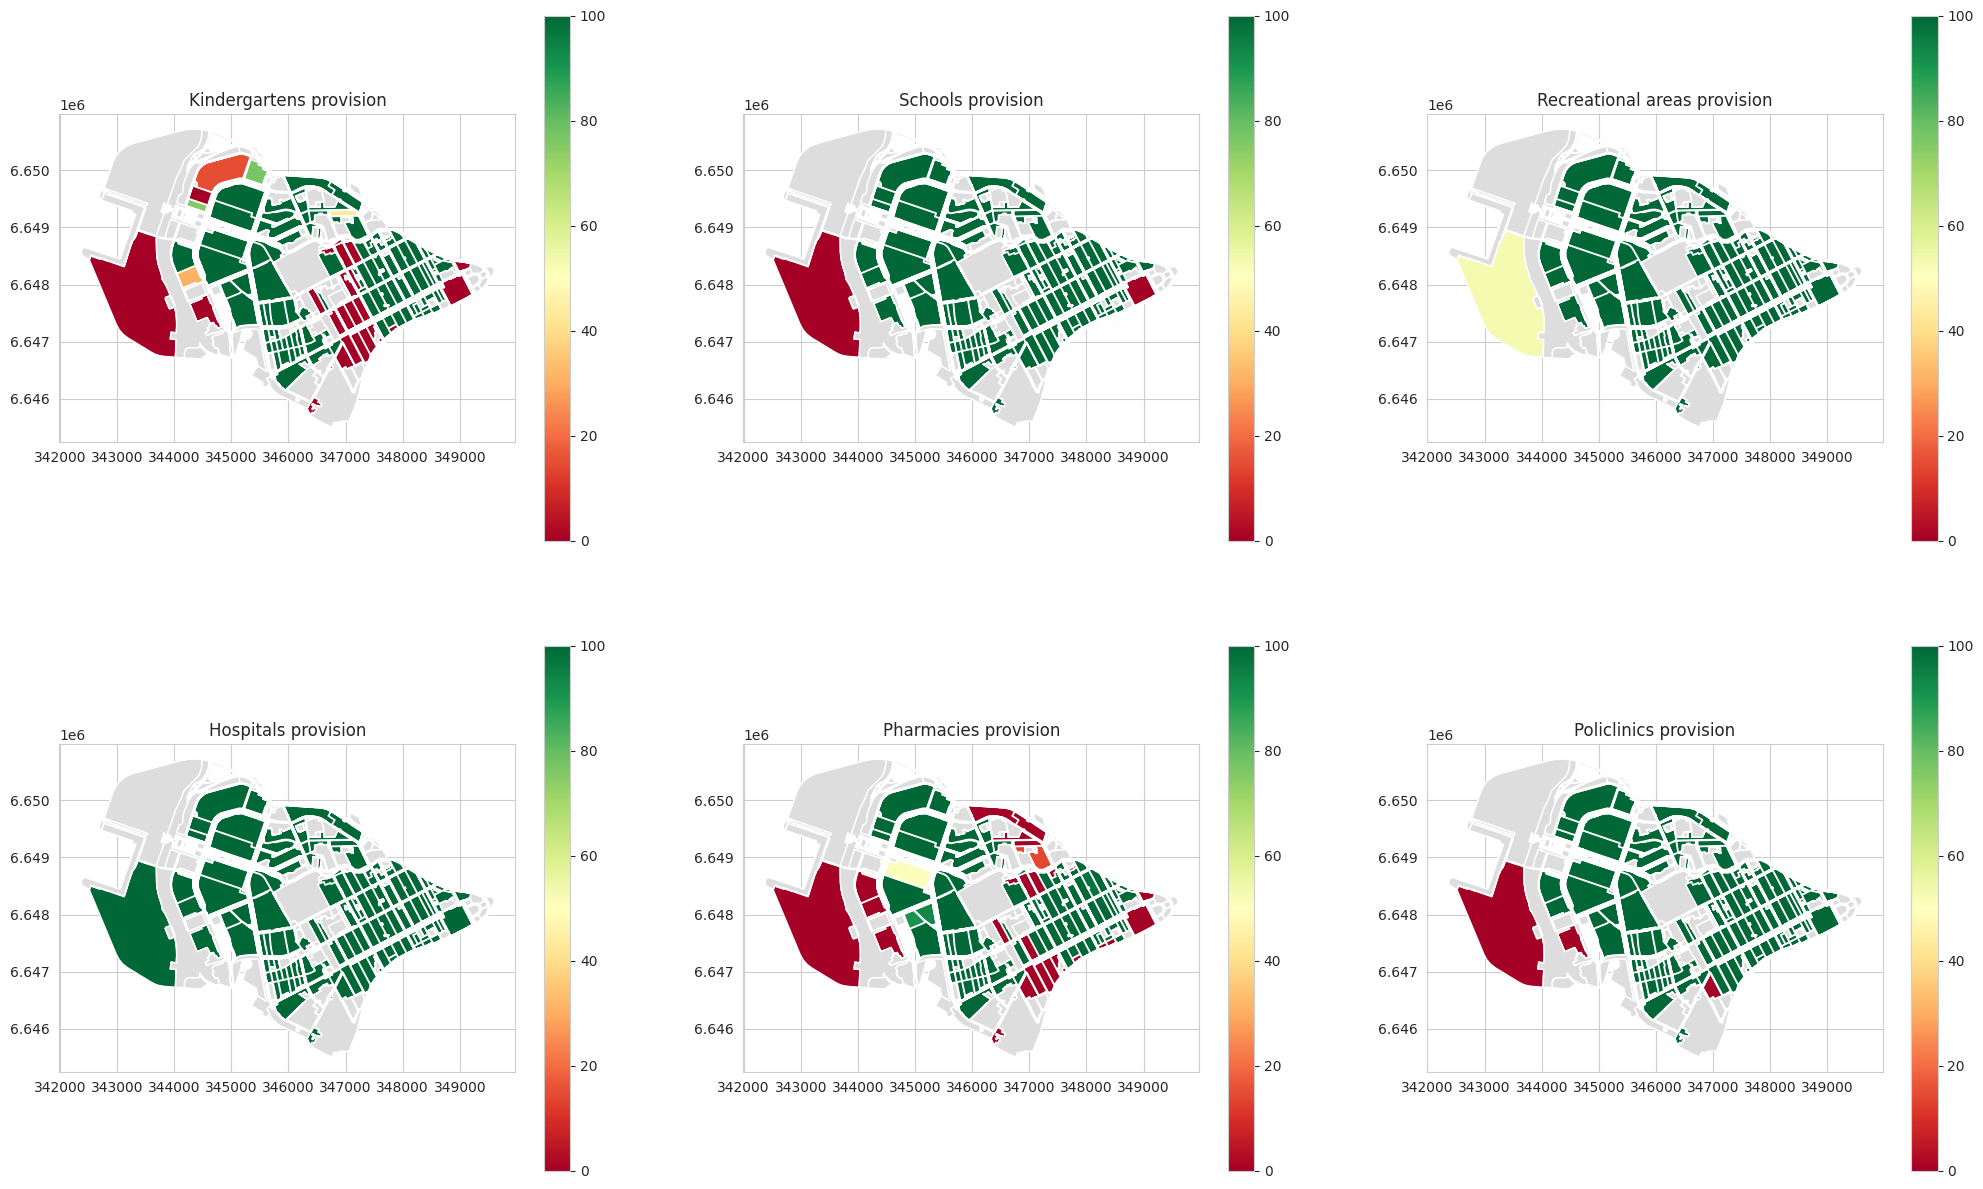

In [ ]:
from matplotlib.gridspec import GridSpec

kindergartens_prov = services_prov["kindergartens"]
schools_prov = services_prov["schools"]
recreational_areas_prov = services_prov["recreational_areas"]
hospitals_prov = services_prov["hospitals"]
pharmacies_prov = services_prov["pharmacies"]
policlinics_prov = services_prov["policlinics"]

fig = plt.figure(figsize=(25, 15))
gs = GridSpec(2, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
kindergartens_prov.plot(column="provision_kindergartens", legend=True, ax=ax1, cmap='RdYlGn')
ax1.set_title("Kindergartens provision")
kindergartens_prov[kindergartens_prov["population"] == 0].plot(ax=ax1, color="#ddd", alpha=1)

ax2 = fig.add_subplot(gs[0, 1])
schools_prov.plot(column="provision_schools", legend=True, ax=ax2, cmap='RdYlGn')
ax2.set_title("Schools provision")
schools_prov[schools_prov["population"] == 0].plot(ax=ax2, color="#ddd", alpha=1)

ax3 = fig.add_subplot(gs[0, 2])
recreational_areas_prov.plot(column="provision_recreational_areas", legend=True, ax=ax3, cmap='RdYlGn')
ax3.set_title("Recreational areas provision")
recreational_areas_prov[recreational_areas_prov["population"] == 0].plot(ax=ax3, color="#ddd", alpha=1)

ax4 = fig.add_subplot(gs[1, 0])
hospitals_prov.plot(column="provision_hospitals", legend=True, ax=ax4, cmap='RdYlGn')
ax4.set_title("Hospitals provision")
hospitals_prov[hospitals_prov["population"] == 0].plot(ax=ax4, color="#ddd", alpha=1)

ax5 = fig.add_subplot(gs[1, 1])
pharmacies_prov.plot(column="provision_pharmacies", legend=True, ax=ax5, cmap='RdYlGn')
ax5.set_title("Pharmacies provision")
pharmacies_prov[pharmacies_prov["population"] == 0].plot(ax=ax5, color="#ddd", alpha=1)

ax6 = fig.add_subplot(gs[1, 2])
policlinics_prov.plot(column="provision_policlinics", legend=True, ax=ax6, cmap='RdYlGn')
ax6.set_title("Policlinics provision")
policlinics_prov[policlinics_prov["population"] == 0].plot(ax=ax6, color="#ddd", alpha=1)

plt.show()


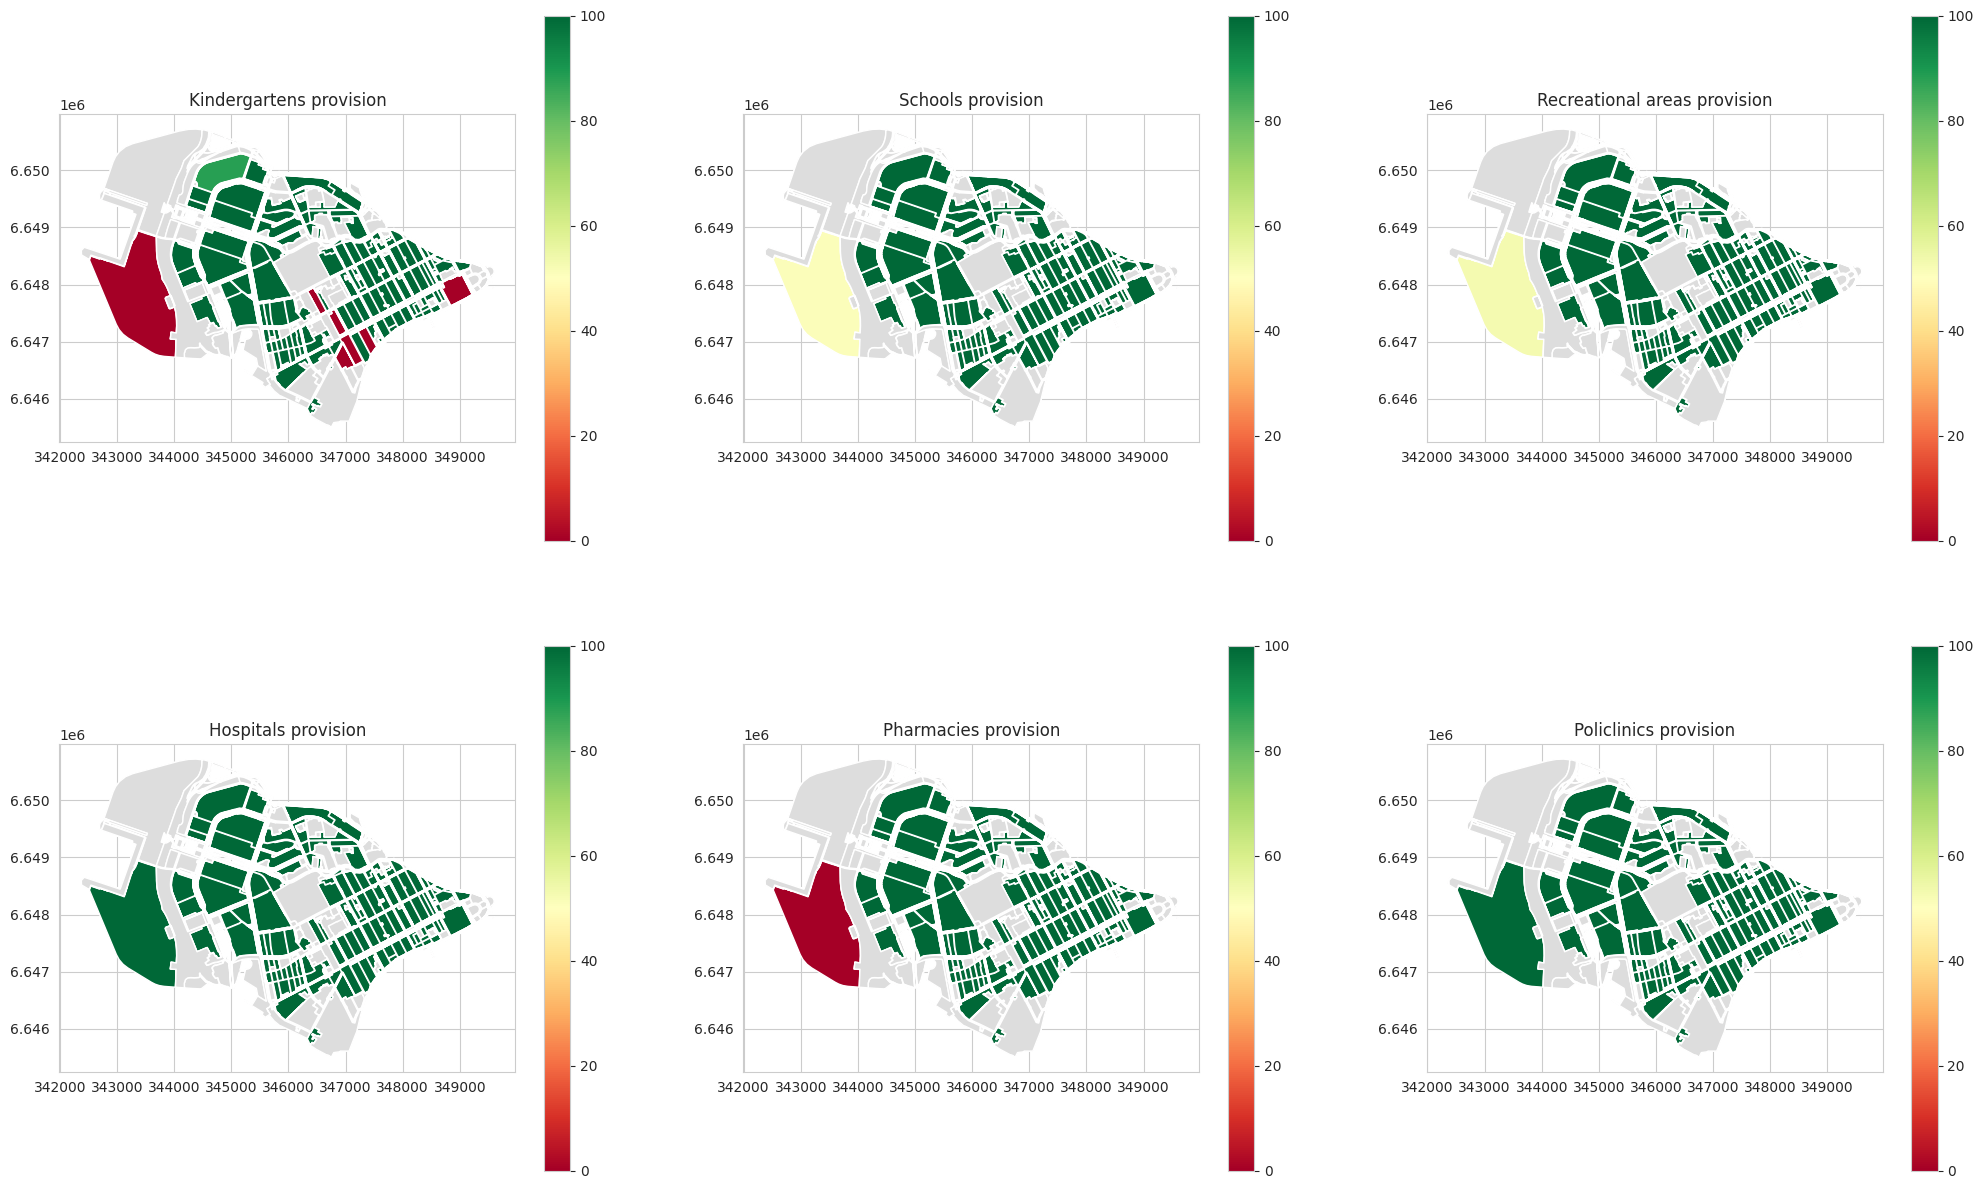

In [ ]:
from matplotlib.gridspec import GridSpec

kindergartens_prov_nev = services_prov_new["kindergartens"]
schools_prov_nev = services_prov_new["schools"]
recreational_areas_prov_nev = services_prov_new["recreational_areas"]
hospitals_prov_nev = services_prov_new["hospitals"]
pharmacies_prov_nev = services_prov_new["pharmacies"]
policlinics_prov_nev = services_prov_new["policlinics"]

fig = plt.figure(figsize=(25, 15))
gs = GridSpec(2, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
kindergartens_prov_nev.plot(column="provision_kindergartens", legend=True, ax=ax1, cmap='RdYlGn')
ax1.set_title("Kindergartens provision")
kindergartens_prov_nev[kindergartens_prov_nev["population"] == 0].plot(ax=ax1, color="#ddd", alpha=1)

ax2 = fig.add_subplot(gs[0, 1])
schools_prov_nev.plot(column="provision_schools", legend=True, ax=ax2, cmap='RdYlGn')
ax2.set_title("Schools provision")
schools_prov_nev[schools_prov_nev["population"] == 0].plot(ax=ax2, color="#ddd", alpha=1)

ax3 = fig.add_subplot(gs[0, 2])
recreational_areas_prov_nev.plot(column="provision_recreational_areas", legend=True, ax=ax3, cmap='RdYlGn')
ax3.set_title("Recreational areas provision")
recreational_areas_prov_nev[recreational_areas_prov_nev["population"] == 0].plot(ax=ax3, color="#ddd", alpha=1)

ax4 = fig.add_subplot(gs[1, 0])
hospitals_prov_nev.plot(column="provision_hospitals", legend=True, ax=ax4, cmap='RdYlGn')
ax4.set_title("Hospitals provision")
hospitals_prov_nev[hospitals_prov_nev["population"] == 0].plot(ax=ax4, color="#ddd", alpha=1)

ax5 = fig.add_subplot(gs[1, 1])
pharmacies_prov_nev.plot(column="provision_pharmacies", legend=True, ax=ax5, cmap='RdYlGn')
ax5.set_title("Pharmacies provision")
pharmacies_prov_nev[pharmacies_prov_nev["population"] == 0].plot(ax=ax5, color="#ddd", alpha=1)

ax6 = fig.add_subplot(gs[1, 2])
policlinics_prov_nev.plot(column="provision_policlinics", legend=True, ax=ax6, cmap='RdYlGn')
ax6.set_title("Policlinics provision")
policlinics_prov_nev[policlinics_prov_nev["population"] == 0].plot(ax=ax6, color="#ddd", alpha=1)

plt.show()